In [1]:
!pip install diffusers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 55.9 MB/s eta 0:00:00


# Text to Image Generation

In [2]:
from diffusers import DiffusionPipeline
import torch

pipe_txt2img = DiffusionPipeline.from_pretrained(
    "playgroundai/playground-v2-1024px-aesthetic",
    torch_dtype=torch.float16,
    use_safetensors=True,
    add_watermarker=False,
    variant="fp16"
)
pipe_txt2img.to("cuda")



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/561 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "playgroundai/playground-v2-1024px-aesthetic",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [3]:
import json

# Step 1: Define default JSON template
default_parameters = {
    "mode":"txt2img",
    "prompt":"Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
    "negative_prompt":"",
    "guidance_scale":2.5,
    "aspect_ratio":"1:1",
    "num_inference_steps":32,
    "init_image":None

}

aspect_ratios={

               "1:1":[1024,1024],
               "9:16":[720,1280],
               "2:3":[836,1254],
               "3:4":[876,1168],
               "4:3":[1168,876],
               "3:2":[1254,836],
               "16:9":[1280,720]

}

# Step 2: Function to update JSON based on another JSON
def update_json(base_json, update_json):
    for key, value in update_json.items():
        if key in base_json:
            base_json[key] = value
    return base_json


input_parameters = {
    "prompt":"Astronaut in a jungle, cold color palette, muted colors, detailed, 8k",
    "negative_prompt":"",
    "guidance_scale":2.5,
    "aspect_ratio":"1:1",
    "num_inference_steps":50

}

input_parameters=update_json(default_parameters,input_parameters)

prompt=input_parameters['prompt']
negative_prompt=input_parameters['negative_prompt']
guidance_scale=input_parameters['guidance_scale']
num_inference_steps=input_parameters['num_inference_steps']
height,width=aspect_ratios[input_parameters['aspect_ratio']]

# height and width shoulb be divisible by 8
height = height - (height % 8)
width = width - (width % 8)


In [4]:
from google.colab import files
import time

start=time.monotonic()
image = pipe_txt2img(prompt=prompt, negative_prompt=negative_prompt, guidance_scale=guidance_scale, height=height, width=width,num_inference_steps=64,).images[0]
print('Inference Time(seconds):',time.monotonic()-start)

  0%|          | 0/64 [00:00<?, ?it/s]

Inference Time(seconds): 56.74348106100001


Output Image


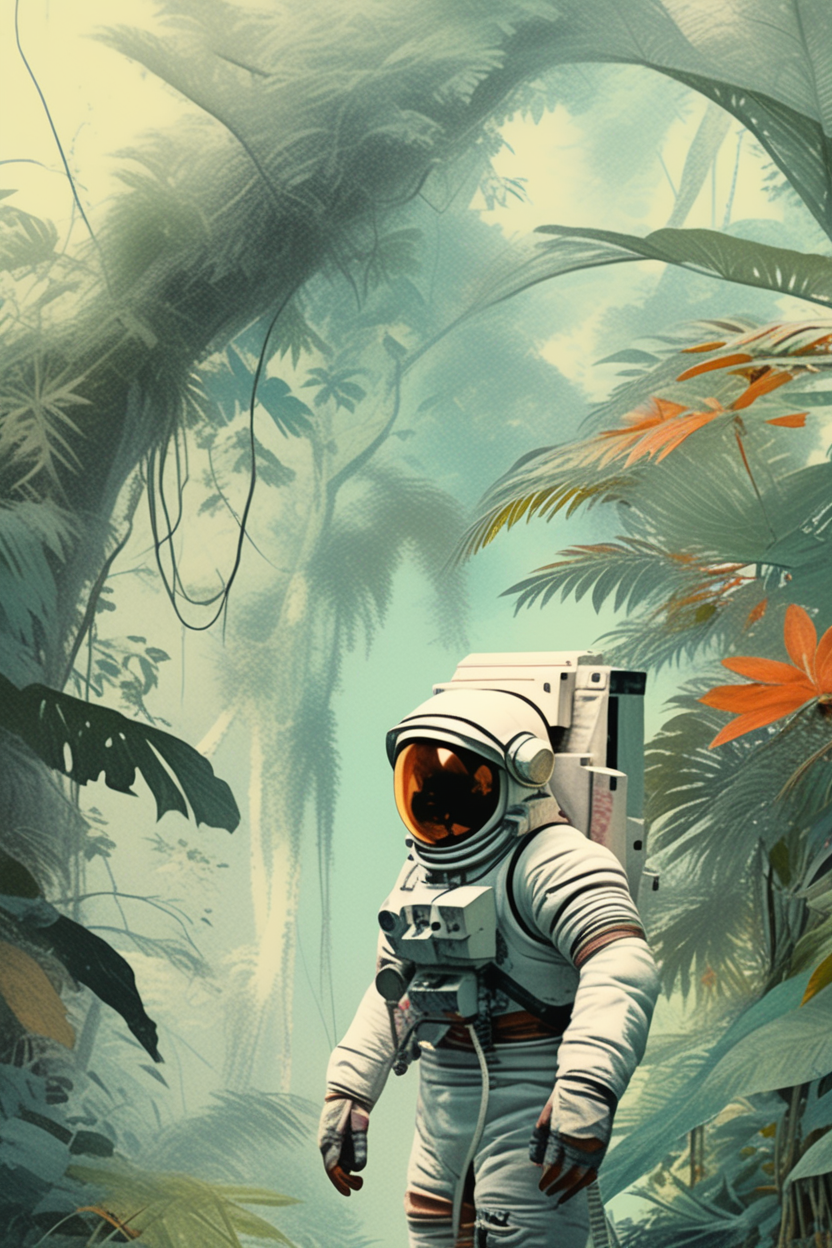

In [5]:
print('Output Image')
image

# Image to Image  Generating / Image Editing

In [6]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe_img2img = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe_img2img.to("cuda")
pipe_img2img.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe_img2img.scheduler.config)


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


turn skin colour into red while keeping background plane white
Input Image


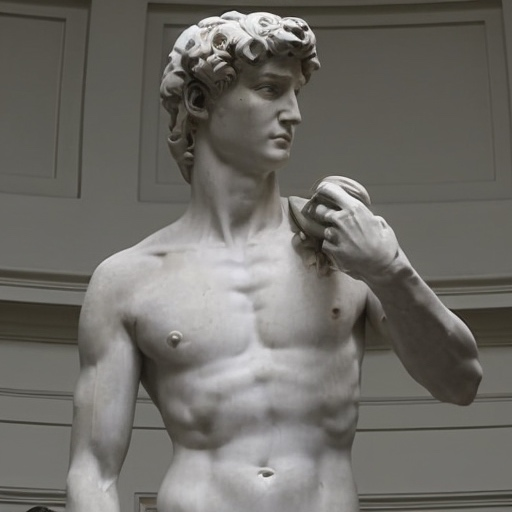

In [29]:
import base64
import io
import PIL
import requests
from io import BytesIO

url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image


image = download_image(url)

input_parameters = {
    "prompt":"turn skin colour into red while keeping background plane white",
    "negative_prompt":"",
    "guidance_scale":5,
    "aspect_ratio":"1:1",
    "num_inference_steps":30,
    "init_image":image

}


prompt=input_parameters['prompt']
negative_prompt=input_parameters['negative_prompt']
guidance_scale=input_parameters['guidance_scale']
num_inference_steps=input_parameters['num_inference_steps']
height,width=aspect_ratios[input_parameters['aspect_ratio']]

height = height - (height % 8)
width = width - (width % 8)
print(prompt)
print('Input Image')
image

  0%|          | 0/30 [00:00<?, ?it/s]

Inference Time (Seconds): 7.0241372010000305


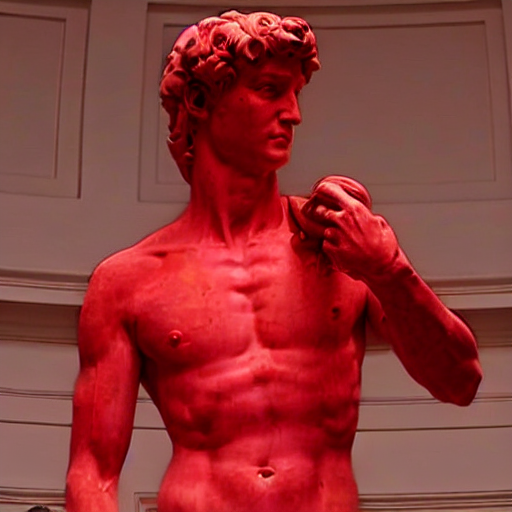

In [30]:
start=time.monotonic()
output_image = pipe_img2img(image=image,prompt=prompt, negative_prompt=negative_prompt, guidance_scale=guidance_scale, height=height, width=width,num_inference_steps=num_inference_steps,).images[0]
print('Inference Time (Seconds):',time.monotonic()-start)
output_image